#### Analytics Engeneering

# Lecture: Common Table Expressions

### Objectives

1. Warmup

2. Definition & Types of CTEs
3. Syntax
4. Example: Warmup Solution with CTEs
5. Benefits and Limitations

6. Bonus: CTE with recursion

## Sub-Queries


Task: Compare number of daily flights on a route ('JFK', 'LAX') to the maximum of daily flights per month.

### SOLUTION (done in dBeaver Script Editor)

 - show daily flight count on a route ('JFK', 'LAX') 

```sql
SELECT flight_date,
       origin, 
       dest,
       COUNT(*) AS flights_per_day 
FROM flights
WHERE (origin, dest) = ('JFK', 'LAX')
GROUP BY flight_date, origin, dest
```

- for each month find the maximum of daily flights.

```sql
SELECT LEFT(flight_date::TEXT, 7) AS yearmonth, 
       origin,
       dest, 
       MAX(flights_per_day) monthly_max_flights_per_day 	
FROM (
      SELECT flight_date,
            origin, 
            dest, 
            COUNT(*) AS flights_per_day 
      FROM flights
      WHERE (origin, dest) = ('JFK', 'LAX')
      GROUP BY flight_date, origin, dest
      ) a
GROUP BY yearmonth, origin, dest

```

- add the monthly maximum of daily flights to each record in the original table 

```sql
SELECT f.flight_date,
	   TO_CHAR(f.flight_date, 'Day') AS weekday, -- adding week day name
		b.origin,
		b.dest,
		COUNT(*) AS flights_per_day,
		MAX(b.monthly_max_flights_per_day) AS monthly_max_flights_per_day
FROM flights f 
JOIN (
			SELECT LEFT(flight_date::TEXT, 7) AS yearmonth, 
				   origin, 
				   dest, 
				   MAX(flights_per_day) monthly_max_flights_per_day 	
			FROM (
					SELECT flight_date,
						   origin, 
						   dest, 
						   COUNT(*) AS flights_per_day 
					FROM flights
					WHERE (origin, dest) = ('JFK', 'LAX')
					GROUP BY flight_date, origin, dest
				  ) a
			GROUP BY yearmonth, origin, dest
			) b
ON LEFT(f.flight_date::TEXT, 7) = b.yearmonth 
	AND f.origin=b.origin 
	AND f.dest=b.dest
GROUP BY flight_date, b.origin, b.dest, b.yearmonth
ORDER BY flight_date, origin, dest
```

The result set should look similar to this:  
  
![image.png](subquery_result.PNG)

# What are CTEs` ?

Common Table Expression, or CTE, is a powerful SQL concept / technique / construct that helps to keep complex queries understandable and more versatile. It first appeared in the SQL standard in **1999**, and the first implementations began appearing in **2005**.

#  2. Definition and Types
Common Table Expressions allow you to create **temporary *named* result sets** from a simple query. You can then use these result sets in subsequent statements of the query. CTEs act as virtual tables, created during the execution of a query, used by the query, and eliminated after query execution.
> **Flashback:** every SQL query returns a result set - a table with records and columns.



### There are two types of CTEs:

**Non-Recursive** CTEs are mainly used for filtering and transforming data, joining tables, also for performing calculations without the need for complex subqueries.

**Recursive** CTEs are helpful when you have to work with hierarchical data, compute recursive aggregates, implement graph algorithms, do recursive calculations like factorials or the Fibonacci series, or generate a sequence of numbers or dates.

# 3. Non-Recursive CTEs

In this lecture we are going to focus on the none-recursive type of Common Table Expressions.


## Syntax

Common Table Expressions start with the **WITH** statement, followed by the **Expression Name**, the name for a **SELECT Statement** inside parantesis, which is the content of a single CTE. You can define one or more common table expression in this fashion. The CTEs construct ends with a **final query** that will give us our result output.

```sql
WITH my_cte AS (
                SELECT column1,
                       column2,
                       column3,
                FROM table_name
               )
               
SELECT * FROM my_cte;
```

# 4. Example

***Let's rewrite the query with subqueries from the Warmup as a CTE Query.***

>### TEACHER's NOTE: start with one CTE, then say:
>"Now we have used just one temporary result set in a WITH clause. But our warmup SQL statement has many subqueries. We need to create more CTEs in a single statement. And we can do that — it is possible to have more CTEs in a single SQL statement."

1. We start with the most-inner query, which returns the count or records (flights) per day.

```sql
WITH daily_flights AS (
    SELECT flight_date,
    	   LEFT(flight_date::TEXT, 7) AS yearmonth,
		   origin, 
		   dest, 
		   COUNT(*) AS flights_per_day 
	FROM flights
	WHERE (origin, dest) = ('JFK', 'LAX')
	GROUP BY flight_date, origin, dest
)
SELECT * 
FROM daily_flights
```

2. Now we have used just one temporary result set in a WITH clause. Let's add the next step and show the maximum monthly maximum count of daily flights. Basically for each month we look at each days total count of flights from JFK to LAX, and pick the biggest.

```sql
WITH daily_flights AS (
    SELECT flight_date,
    	   LEFT(flight_date::TEXT, 7) AS yearmonth,
		   origin, 
		   dest, 
		   COUNT(*) AS flights_per_day 
	FROM flights
	WHERE (origin, dest) = ('JFK', 'LAX')
	GROUP BY flight_date, origin, dest
),
monthly_flights AS (
    SELECT yearmonth, 
		   origin, 
		   dest, 
		   MAX(flights_per_day) monthly_max_flights_per_day
	FROM daily_flights
	GROUP BY yearmonth, origin, dest
)

SELECT * 
FROM monthly_flights
```

>- the `rates_max` CTE is quering from the `rate_avg` CTE
>- the final SELECT statement is quering from a different CTE

3. At last we need to perform a JOIN in order to add the monthly maximums of daily flights to each record in the original table. We can do it in the final SELECT statement.
   
```sql
WITH daily_flights AS (
    SELECT flight_date,
    	   LEFT(flight_date::TEXT, 7) AS yearmonth,
		   origin, 
		   dest, 
		   COUNT(*) AS flights_per_day 
	FROM flights
	WHERE (origin, dest) = ('JFK', 'LAX')
	GROUP BY flight_date, origin, dest
),
monthly_flights AS (
    SELECT yearmonth, 
		   origin, 
		   dest, 
		   MAX(flights_per_day) monthly_max_flights_per_day
	FROM daily_flights
	GROUP BY yearmonth, origin, dest
)
SELECT
    flight_date,
    --TO_CHAR(flight_date, 'Day') AS weekday,
	origin,
	dest,
	flights_per_day,
	monthly_max_flights_per_day
FROM daily_flights d
JOIN monthly_flights m
USING (yearmonth, origin, dest)
ORDER BY flight_date, origin, dest;
```

##### Bonus Tasks:
In the final result add for each record in the original table
- a column showing the weekday name
- a column with the capacity ratio: daily count / monthly max 
- can we move the joins to a separate CTE step? 

# 5. In a Nutshell

As you can see with CTEs we can perform Multistage Data Transformation in a linear step-by-step way.

### Benefits of CTEs

- **Readability:** the query logic is easier to follow and to understand
- **Resusage of intermediate results:** a CTE can be referenced multiple times in a query
- **Maintanance:** single steps can be easily tested, which helps a lot when debugging or optimising a query
- **Substitute for a VIEW:** often DB permissions do not allow saving VIEWs, also usage of VIEWs can be significantly more expensive
- **Recursive ability:** Self-referencing queries (see below)

### Limitations of CTEs

- **Duration and scope:** CTEs results are used only within a query and are not stored in the database
- **Indexing**: Because CTEs are not stored in a database as just temporary result sets they can't be indexed
- **Conditions:** CTE's can't be used in the WHERE clause
- **Nesting:** Depending the meaning of Nesting. For once it is not possible to start another CTE chain within a CTE. If you mean by "nested CTEs" multiple CTEs keep in mind that some databases limit the number of CTEs used in a query.
- **Compatibility:** Even though CTEs are quite popular, some database management systems do not support them, or have limited support.


## Excurse: CTE vs Subquery



|CTE|Subquery|
|:---|:---|
|Typically more readable since CTEs can be used to give structure to your query	|Typically less readable, especially if there are many nested queries|
|Allows for recursiveness |Does not allow for recursiveness|
|CTEs must have unique CTE_EXPRESSION_NAMES when used in a query |Subqueries don’t always have to be explicitly named|
|CTEs cannot be used in a WHERE clause	|Subqueries can be used in a WHERE clause|

># 6. What about Recursive CTEs?
>
>Recursive CTEs are used in management of hierarchical or graph-based data structures, or for generating sequences of numbers or dates, calculating the Fibonacci sequence or factorials, etc.
>
>It is used to solve problems requiring repeated processing (kind of loops) of the same data aka recursion. The recursive query references itself until a condition met. This condition has to be specified in a WHERE clause to stop the recursion.
>
>**Example:** Generate a sequence of numbers from 1 to 50.  
NOTE: This is a Microsoft SQL Server dialect example. PostgreSQL recursive CTE statement starts like this: `WITH RECURSIVE...`
>
> 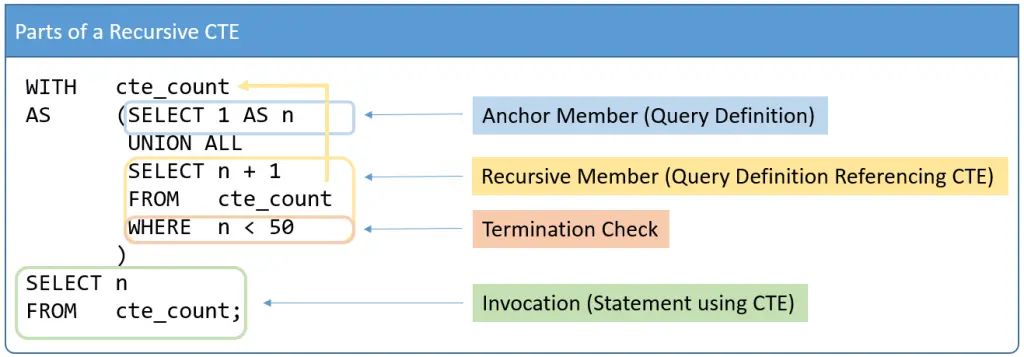
>
>Source: <a href="https://www.essentialsql.com/introduction-common-table-expressions-ctes/">
Common Table Expressions – The Ultimate Guide</a> By: Kris Wenzel <a href="https://www.essentialsql.com/">essentialsql.com</a>  
<br><br>  
>
>**More information:**  
><a href='https://www.stratascratch.com/blog/learn-to-use-a-recursive-cte-in-sql-query/'>How to Use a Recursive CTE in SQL Query</a> 